In [19]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import warnings
warnings.filterwarnings('ignore')
import tqdm
import tensorflow_addons as tfa


In [2]:
import pathlib
data_dir = pathlib.Path('/Users/alfahwun/Documents/faces')


In [3]:
image_count = len(list(data_dir.glob('*/*')))
print(image_count)

1036


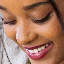

In [4]:
smiling = list(data_dir.glob('smiling/*'))
PIL.Image.open(str(smiling[2]))


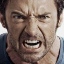

In [5]:
angry = list(data_dir.glob('angry/*'))
PIL.Image.open(str(angry[2]))


In [24]:
batch_size = 32
img_height = 64
img_width = 64


In [25]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)


Found 1035 files belonging to 2 classes.
Using 828 files for training.


In [26]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 1035 files belonging to 2 classes.
Using 207 files for validation.


In [27]:
class_names = train_ds.class_names
print(class_names)

['angry', 'smiling']


In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [29]:
normalization_layer = layers.Rescaling(1./255)

In [30]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [31]:
from tensorflow.keras.optimizers.legacy import Adam

In [32]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal",
                          input_shape=(img_height,
                                       img_width,
                                       3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

In [33]:
num_classes = len(class_names)
model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])


In [34]:
model.compile(optimizer=Adam(),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [35]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 64, 64, 3)         0         
                                                                 
 rescaling_3 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 conv2d_3 (Conv2D)           (None, 64, 64, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 32, 32, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

In [36]:
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [37]:
epochs = 50
history = model.fit(
    normalized_ds,
    validation_data=val_ds,
    epochs=epochs,
    verbose=0,
    callbacks=[tqdm_callback]
)

Training:   0%|           0/50 ETA: ?s,  ?epochs/s

Epoch 1/50


0/26           ETA: ?s - 

2023-03-06 20:46:22.642146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-03-06 20:46:33.502716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 2/50


0/26           ETA: ?s - 

Epoch 3/50


0/26           ETA: ?s - 

Epoch 4/50


0/26           ETA: ?s - 

Epoch 5/50


0/26           ETA: ?s - 

Epoch 6/50


0/26           ETA: ?s - 

Epoch 7/50


0/26           ETA: ?s - 

Epoch 8/50


0/26           ETA: ?s - 

Epoch 9/50


0/26           ETA: ?s - 

Epoch 10/50


0/26           ETA: ?s - 

Epoch 11/50


0/26           ETA: ?s - 

Epoch 12/50


0/26           ETA: ?s - 

Epoch 13/50


0/26           ETA: ?s - 

Epoch 14/50


0/26           ETA: ?s - 

Epoch 15/50


0/26           ETA: ?s - 

Epoch 16/50


0/26           ETA: ?s - 

Epoch 17/50


0/26           ETA: ?s - 

Epoch 18/50


0/26           ETA: ?s - 

Epoch 19/50


0/26           ETA: ?s - 

Epoch 20/50


0/26           ETA: ?s - 

Epoch 21/50


0/26           ETA: ?s - 

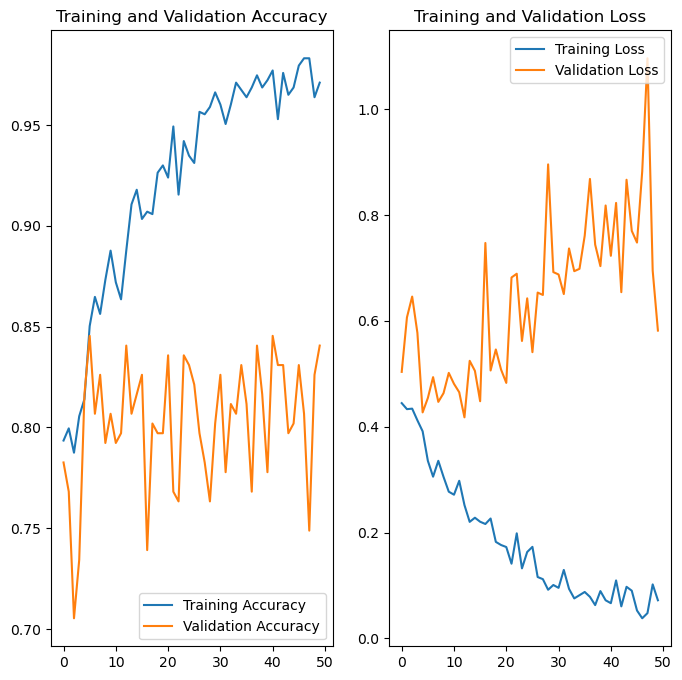

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [56]:
img = tf.keras.utils.load_img(
    "/Users/alfahwun/Downloads/WhatsApp Image 2023-02-12 at 22.54.50.jpeg", target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.sigmoid(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 39ms/step
This image most likely belongs to angry with a 99.88 percent confidence.


In [33]:
score

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.92363864, 0.11774307], dtype=float32)>